# Soybean Leaf Disease: CNN Baseline

## Why This Experiment?

**Goal**: Train ConvNeXt Tiny on ASDID dataset and establish baseline performance for:
1. **In-domain**: ASDID test set (same distribution as training)
2. **Cross-domain**: MH dataset (target domain for TTA experiments)

## Expected Results

| Dataset | Expected F1 |
|---------|-------------|
| ASDID (in-domain) | > 0.85 |
| MH (cross-domain) | ~ 0.68 |

The performance drop on MH reflects the domain shift challenge that TTA methods will address.

## Setup

In [1]:
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

# Add src to path
sys.path.insert(0, os.path.abspath('../'))

from src.models.architectures import get_model
from src.dataset.loaders import get_dataloaders
from src.utils.metrics import evaluate_model_full, print_metrics
from src.utils.plotting import plot_confusion_matrix, plot_training_curves
from src.utils.logging import save_checkpoint, log_experiment

# Configuration
SEED = 21
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
BATCH_SIZE = 32
NUM_EPOCHS = 3
MODEL_NAME = 'resnet50'
RESULTS_DIR = Path('results')
RESULTS_DIR.mkdir(exist_ok=True)

# Set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

print(f"Device: {DEVICE}")
print(f"Model: {MODEL_NAME}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")

Device: mps
Model: resnet50
Batch size: 32
Epochs: 3


## Load Datasets

In [2]:
# Load ASDID dataset (training source)
print("Loading ASDID dataset...")
asdid_train_loader, asdid_val_loader, asdid_test_loader, asdid_dataset, _, _, _ = get_dataloaders(
    dataset_name='ASDID',
    data_root='../data/ASDID',
    batch_size=BATCH_SIZE,
    train_val_test_split=(0.7, 0.15, 0.15),
    seed=SEED
)

print(f"ASDID - Train: {len(asdid_train_loader.dataset)}, "
      f"Val: {len(asdid_val_loader.dataset)}, "
      f"Test: {len(asdid_test_loader.dataset)}")

# Load MH dataset (target domain for cross-domain evaluation)
print("\nLoading MH dataset...")
mh_train_loader, mh_val_loader, mh_test_loader, mh_dataset, _, _, _ = get_dataloaders(
    dataset_name='MH',
    data_root='../data/MH-SoyaHealthVision/Soyabean_Leaf_Image_Dataset',
    batch_size=BATCH_SIZE,
    train_val_test_split=(0.7, 0.15, 0.15),
    seed=SEED
)

print(f"MH - Train: {len(mh_train_loader.dataset)}, "
      f"Val: {len(mh_val_loader.dataset)}, "
      f"Test: {len(mh_test_loader.dataset)}")

CLASS_NAMES = ['Healthy', 'Rust', 'Frogeye']

Loading ASDID dataset...
Loaded 4799 samples for ASDID dataset.
ASDID - Train: 3359, Val: 719, Test: 721

Loading MH dataset...
Loaded 1225 samples for MH dataset.
MH - Train: 857, Val: 183, Test: 185


## Train Model on ASDID

In [3]:
# Initialize model
model = get_model(MODEL_NAME, num_classes=3, device=DEVICE)
print(f"\nModel architecture: {MODEL_NAME}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# Training loop
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_f1 = 0.0
best_epoch = 0

print("\n" + "="*60)
print("Starting Training")
print("="*60)

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_bar = tqdm(asdid_train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} [Train]", leave=False)
    for images, labels in train_bar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        train_bar.set_postfix(loss=loss.item())
    
    train_loss /= len(asdid_train_loader)
    train_acc = train_correct / train_total
    
    # Validation phase
    model.eval()
    val_metrics = evaluate_model_full(model, asdid_val_loader, device=DEVICE, class_names=CLASS_NAMES)
    val_loss = train_loss  # Placeholder (not computing val loss separately for simplicity)
    val_acc = val_metrics['accuracy']
    val_f1 = val_metrics['f1']
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print progress
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch + 1
        save_checkpoint(
            model,
            RESULTS_DIR / f'best_{MODEL_NAME}.pth',
            metadata={
                'model_name': MODEL_NAME,
                'epoch': epoch + 1,
                'val_f1': val_f1,
                'val_acc': val_acc
            }
        )
    
    scheduler.step()

print(f"\n✅ Training complete! Best validation F1: {best_val_f1:.4f} (Epoch {best_epoch})")


Model architecture: resnet50
Total parameters: 23,514,179

Starting Training


Epoch 1/3 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1/3 | Train Loss: 0.4004 | Train Acc: 0.8631 | Val Acc: 0.9764 | Val F1: 0.9761
✅ Saved checkpoint to results/best_resnet50.pth


Epoch 2/3 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2/3 | Train Loss: 0.0541 | Train Acc: 0.9830 | Val Acc: 0.9764 | Val F1: 0.9759


Epoch 3/3 [Train]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3/3 | Train Loss: 0.0262 | Train Acc: 0.9935 | Val Acc: 0.9833 | Val F1: 0.9832
✅ Saved checkpoint to results/best_resnet50.pth

✅ Training complete! Best validation F1: 0.9832 (Epoch 3)


## Plot Training Curves

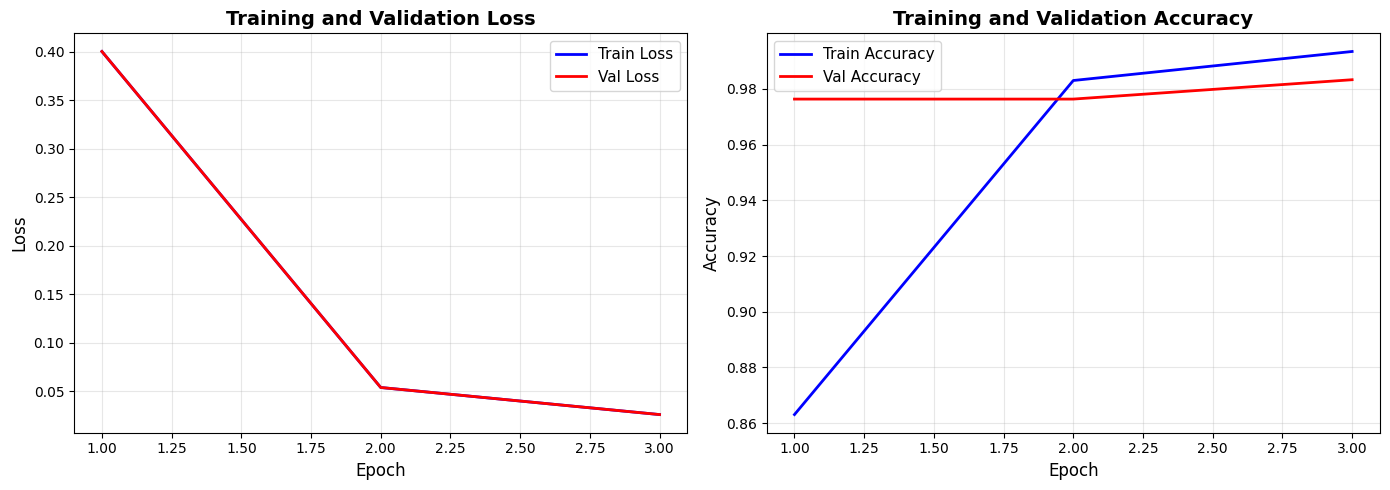

In [4]:
plot_training_curves(history, save_path=RESULTS_DIR / f'{MODEL_NAME}_training_curves.png')
plt.show()

## In-Domain Evaluation (ASDID Test Set)

✅ Loaded checkpoint from results/best_resnet50.pth

                 ASDID Test Set (In-Domain)                 
Accuracy:  0.9806
Precision: 0.9802
Recall:    0.9806
F1 Score:  0.9803

---------------------Per-Class Metrics:---------------------

Healthy:
  Precision: 0.9922
  Recall:    0.9808
  F1 Score:  0.9865
  Support:   260

Rust:
  Precision: 0.9913
  Recall:    0.9786
  F1 Score:  0.9849
  Support:   234

Frogeye:
  Precision: 0.9571
  Recall:    0.9824
  F1 Score:  0.9696
  Support:   227



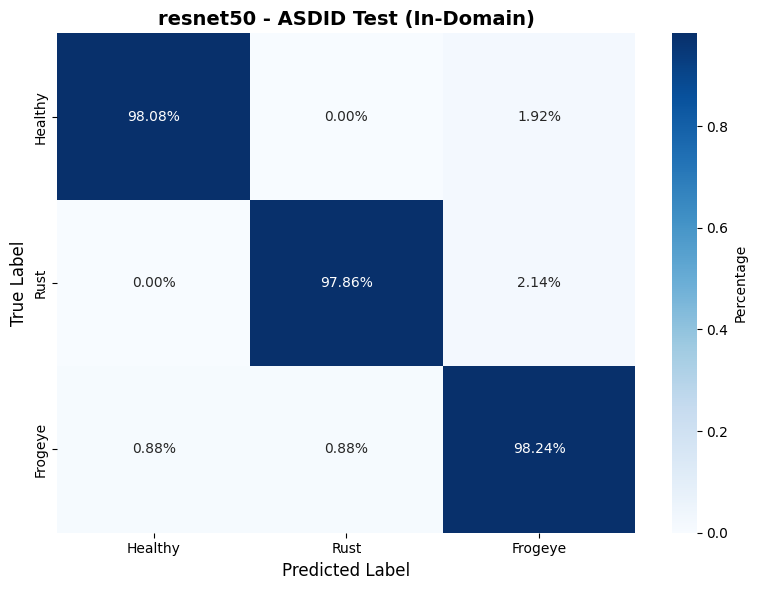

✅ Logged experiment to results/experiment_registry.csv


PosixPath('results/experiment_registry.csv')

In [5]:
# Load best model
from src.utils.logging import load_checkpoint
model = get_model(MODEL_NAME, num_classes=3, device=DEVICE)
load_checkpoint(RESULTS_DIR / f'best_{MODEL_NAME}.pth', model, device=DEVICE)

# Evaluate on ASDID test set
asdid_test_metrics = evaluate_model_full(model, asdid_test_loader, device=DEVICE, class_names=CLASS_NAMES)
print_metrics(asdid_test_metrics, title="ASDID Test Set (In-Domain)")

# Plot confusion matrix
plot_confusion_matrix(
    asdid_test_metrics['confusion_matrix'],
    class_names=CLASS_NAMES,
    title=f'{MODEL_NAME} - ASDID Test (In-Domain)',
    save_path=RESULTS_DIR / f'{MODEL_NAME}_asdid_confusion.png'
)
plt.show()

# Log results
log_experiment(
    experiment_name=f'{MODEL_NAME}_baseline_asdid',
    metrics=asdid_test_metrics,
    model_name=MODEL_NAME,
    dataset='ASDID',
    method='baseline',
    save_dir='results',
    notes='In-domain test on ASDID'
)

## Cross-Domain Evaluation (MH Test Set)


            MH Test Set (Cross-Domain Baseline)             
Accuracy:  0.7351
Precision: 0.7102
Recall:    0.7732
F1 Score:  0.7151

---------------------Per-Class Metrics:---------------------

Healthy:
  Precision: 0.9375
  Recall:    1.0000
  F1 Score:  0.9677
  Support:   30

Rust:
  Precision: 0.9100
  Recall:    0.6947
  F1 Score:  0.7879
  Support:   131

Frogeye:
  Precision: 0.2830
  Recall:    0.6250
  F1 Score:  0.3896
  Support:   24



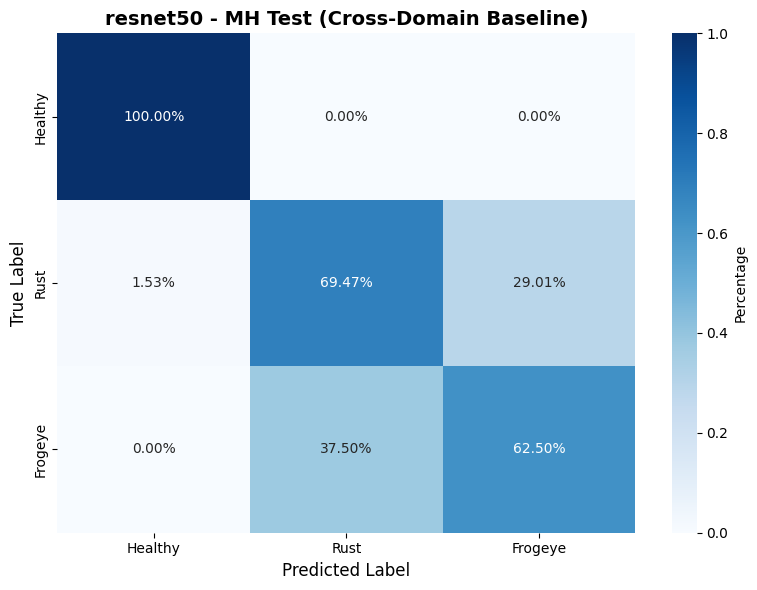

✅ Logged experiment to results/experiment_registry.csv

Summary: resnet50 Baseline
ASDID (in-domain) F1:    0.9803
MH (cross-domain) F1:    0.7151
Performance drop:        0.2652


In [6]:
# Evaluate on MH test set (without adaptation)
mh_baseline_metrics = evaluate_model_full(model, mh_test_loader, device=DEVICE, class_names=CLASS_NAMES)
print_metrics(mh_baseline_metrics, title="MH Test Set (Cross-Domain Baseline)")

# Plot confusion matrix
plot_confusion_matrix(
    mh_baseline_metrics['confusion_matrix'],
    class_names=CLASS_NAMES,
    title=f'{MODEL_NAME} - MH Test (Cross-Domain Baseline)',
    save_path=RESULTS_DIR / f'{MODEL_NAME}_mh_baseline_confusion.png'
)
plt.show()

# Log results
log_experiment(
    experiment_name=f'{MODEL_NAME}_baseline_mh',
    metrics=mh_baseline_metrics,
    model_name=MODEL_NAME,
    dataset='MH',
    method='baseline',
    save_dir='results',
    notes='Cross-domain baseline without TTA'
)

print(f"\n{'='*60}")
print(f"Summary: {MODEL_NAME} Baseline")
print(f"{'='*60}")
print(f"ASDID (in-domain) F1:    {asdid_test_metrics['f1']:.4f}")
print(f"MH (cross-domain) F1:    {mh_baseline_metrics['f1']:.4f}")
print(f"Performance drop:        {asdid_test_metrics['f1'] - mh_baseline_metrics['f1']:.4f}")
print(f"{'='*60}")